# Creating a simple GNN Music Recommender System

## Loading Data

Data is from #nowplaying dataset. 

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import GroupShuffleSplit # used for splitting data 
from torch_geometric.data import Data


#TODO: Split datasets by removing edges for valid and test splits
#TODO: Incorporate high and low level audio features
#TODO: Incorporate music context
#TODO: Fuse layers together (attention?)
#TODO: Rerun M4A-Onion


In [2]:
# Loading data
data_dir = os.path.normpath(r'D:\Projects\cs224-multimodal-recommender-system\processed_data\nowplaying')

train = pd.read_parquet(
    os.path.join(data_dir, 'session_candidates_train_v2.parquet')
)

valid = pd.read_parquet(
    os.path.join(data_dir, 'session_candidates_valid_v2.parquet')
)

test = pd.read_parquet(
    os.path.join(data_dir, 'session_candidates_test_v2.parquet')
)

features = pd.read_parquet(
    os.path.join(data_dir, 'Lyrics_HSP-L_Nowplay_Data.parquet')
)

track_map = pd.read_parquet(
    os.path.join(data_dir, 'track_id_map.parquet')
).set_index(['Artist', 'Title'])


## View data

In [7]:
track_features = (features
                  .drop_duplicates(subset= ['Artist', 'Title'], keep = 'first')
                  .drop(columns = ['user id', 'source of the tweet', 'track title', 'artist name', ])
                  )
print('Initial number of tracks:', track_features.shape[0])
track_features = track_features.merge(track_map, on = ['Artist', 'Title'], how = 'inner')
track_features = (track_features
                  .set_index('track_id')
                  .lyrics_embedding
                  .apply(lambda x: pd.Series(x))
                  )

print('Number of tracks post-inner join:', track_features.shape[0])
print('Track features')
print(79*'-')
display(track_features.head())

train_user_listening_history = train.loc[:, ['user', 'past_interactions']]
print('Train: User listening history')
print(79*'-')
display(train_user_listening_history.head())


train_user_item_interactions = train.loc[:, ['user', 'positive_song_id']]
print('Train: User-item interactions')
print(79*'-')
display(train_user_item_interactions.head())

train_user_item_all_interactions = train.loc[: , ['user', 'candidates']].explode('candidates').rename(columns = {'candidates': 'song_id'})
print('Train: User-item negative + positive interactions')
print(79*'-')
display(train_user_item_all_interactions.head())

train_track_features = track_features.loc[train_user_item_all_interactions.song_id.unique(), :]

# positive interaction tuples
train_positive_interactions_set = set(
    train_user_item_interactions
    .drop_duplicates()
    .apply(lambda x: (x['user'], x['positive_song_id']), axis = 1)
    .to_list()
)

valid_user_listening_history = valid.loc[:, ['user', 'past_interactions']]
print('Valid: User listening history')
print(79*'-')
display(valid_user_listening_history.head())


valid_user_item_interactions = valid.loc[:, ['user', 'positive_song_id']]
print('Valid: User-item interactions')
print(79*'-')
display(valid_user_item_interactions.head())

valid_user_item_all_interactions = valid.loc[: , ['user', 'candidates']].explode('candidates').rename(columns = {'candidates': 'song_id'})
print('Valid: User-item negative + positive interactions')
print(79*'-')
display(valid_user_item_all_interactions.head())

valid_track_features = track_features.loc[valid_user_item_all_interactions.song_id.unique(), :]

# positive interactions set
valid_positive_interactions_set = set(
    valid_user_item_interactions
    .drop_duplicates()
    .apply(lambda x: (x['user'], x['positive_song_id']), axis = 1)
    .to_list()
)

test_user_listening_history = test.loc[:, ['user', 'past_interactions']]
print('Test: User listening history')
print(79*'-')
display(test_user_listening_history.head())


test_user_item_interactions = test.loc[:, ['user', 'positive_song_id']]
print('Test: User-item interactions')
print(79*'-')
display(test_user_item_interactions.head())

test_user_item_all_interactions = test.loc[: , ['user', 'candidates']].explode('candidates').rename(columns = {'candidates': 'song_id'})
print('Test: User-item negative + positive interactions')
print(79*'-')
display(test_user_item_all_interactions.head())

test_track_features = track_features.loc[test_user_item_all_interactions.song_id.unique(), :]

test_positive_interactions_set = set(
    test_user_item_interactions
    .drop_duplicates()
    .apply(lambda x: (x['user'], x['positive_song_id']), axis = 1)
    .to_list()
)



Initial number of tracks: 2471
Number of tracks post-inner join: 2155
Track features
-------------------------------------------------------------------------------


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
track_id,,,,,,,,,,,,,,,,,,,,,
1,-0.016555,0.016258,0.032462,-0.065711,0.035892,-0.030516,0.044030,0.046941,0.031009,-0.051097,...,0.137975,-0.032969,-0.178082,0.032461,0.081872,0.018873,0.134802,-0.184255,-0.020970,-0.009385
2,-0.043866,0.079759,0.031227,-0.009023,0.198229,-0.117961,0.023687,0.126027,0.002055,-0.055694,...,0.082887,-0.094865,-0.103203,0.029579,0.168657,0.054824,0.156257,0.036643,-0.045506,-0.051694
3,0.040213,0.071726,-0.022398,-0.148623,0.250008,-0.033887,0.026806,0.242937,0.030847,0.016596,...,0.093019,-0.006108,-0.108450,0.160098,0.071841,0.118777,0.233991,0.042564,-0.028533,-0.093544
4,-0.009909,-0.046708,0.058077,0.009227,0.064153,-0.003633,0.027486,0.102278,0.117365,-0.024824,...,0.100890,-0.193991,-0.133274,0.108100,0.134432,0.114251,0.241544,-0.116317,-0.074772,-0.075406
5,0.003207,0.011662,0.044229,-0.107282,0.164013,-0.027828,0.017900,0.089839,0.104875,-0.010808,...,0.083276,-0.045836,-0.046923,0.081197,0.055439,0.086655,0.196141,-0.123199,-0.025011,0.013837


Train: User listening history
-------------------------------------------------------------------------------


,user,past_interactions
0,102361c889eac74438c3c9ba221124e79cdd14ed,"[554, 19, 554, 238, 223, 238, 19, 554, 238, 238]"
1,102361c889eac74438c3c9ba221124e79cdd14ed,"[19, 554, 238, 223, 238, 19, 554, 238, 238, 554]"
2,102361c889eac74438c3c9ba221124e79cdd14ed,"[554, 238, 223, 238, 19, 554, 238, 238, 554, 554]"
3,102361c889eac74438c3c9ba221124e79cdd14ed,"[238, 223, 238, 19, 554, 238, 238, 554, 554, 238]"
4,102361c889eac74438c3c9ba221124e79cdd14ed,"[223, 238, 19, 554, 238, 238, 554, 554, 238, 238]"


Train: User-item interactions
-------------------------------------------------------------------------------


,user,positive_song_id
0,102361c889eac74438c3c9ba221124e79cdd14ed,554
1,102361c889eac74438c3c9ba221124e79cdd14ed,554
2,102361c889eac74438c3c9ba221124e79cdd14ed,238
3,102361c889eac74438c3c9ba221124e79cdd14ed,238
4,102361c889eac74438c3c9ba221124e79cdd14ed,554


Train: User-item negative + positive interactions
-------------------------------------------------------------------------------


,user,song_id
0,102361c889eac74438c3c9ba221124e79cdd14ed,554
0,102361c889eac74438c3c9ba221124e79cdd14ed,1533
0,102361c889eac74438c3c9ba221124e79cdd14ed,486
0,102361c889eac74438c3c9ba221124e79cdd14ed,992
0,102361c889eac74438c3c9ba221124e79cdd14ed,1544


Valid: User listening history
-------------------------------------------------------------------------------


,user,past_interactions
0,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[96, 46, 46, 46, 46, 232, 325, 232, 125, 325]"
1,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[46, 46, 46, 46, 232, 325, 232, 125, 325, 125]"
2,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[46, 46, 46, 232, 325, 232, 125, 325, 125, 232]"
3,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[46, 46, 232, 325, 232, 125, 325, 125, 232, 46]"
4,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[46, 232, 325, 232, 125, 325, 125, 232, 46, 96]"


Valid: User-item interactions
-------------------------------------------------------------------------------


,user,positive_song_id
0,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,125
1,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,232
2,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,46
3,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,96
4,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,325


Valid: User-item negative + positive interactions
-------------------------------------------------------------------------------


,user,song_id
0,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,1345
0,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,117
0,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,1069
0,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,593
0,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,166


Test: User listening history
-------------------------------------------------------------------------------


,user,past_interactions
0,103aaf06662cc01fe8b1ddaa39e41f59a8332832,"[595, 84, 152, 614, 688, 48, 34, 191, 1362, 171]"
1,103aaf06662cc01fe8b1ddaa39e41f59a8332832,"[84, 152, 614, 688, 48, 34, 191, 1362, 171, 111]"
2,103aaf06662cc01fe8b1ddaa39e41f59a8332832,"[152, 614, 688, 48, 34, 191, 1362, 171, 111, 196]"
3,103aaf06662cc01fe8b1ddaa39e41f59a8332832,"[614, 688, 48, 34, 191, 1362, 171, 111, 196, 152]"
4,103aaf06662cc01fe8b1ddaa39e41f59a8332832,"[688, 48, 34, 191, 1362, 171, 111, 196, 152, 643]"


Test: User-item interactions
-------------------------------------------------------------------------------


,user,positive_song_id
0,103aaf06662cc01fe8b1ddaa39e41f59a8332832,111
1,103aaf06662cc01fe8b1ddaa39e41f59a8332832,196
2,103aaf06662cc01fe8b1ddaa39e41f59a8332832,152
3,103aaf06662cc01fe8b1ddaa39e41f59a8332832,643
4,103aaf06662cc01fe8b1ddaa39e41f59a8332832,144


Test: User-item negative + positive interactions
-------------------------------------------------------------------------------


,user,song_id
0,103aaf06662cc01fe8b1ddaa39e41f59a8332832,1340
0,103aaf06662cc01fe8b1ddaa39e41f59a8332832,111
0,103aaf06662cc01fe8b1ddaa39e41f59a8332832,1033
0,103aaf06662cc01fe8b1ddaa39e41f59a8332832,1690
0,103aaf06662cc01fe8b1ddaa39e41f59a8332832,1988


## Prepare Graph

In [8]:
train_user_item_interactions.head()

,user,positive_song_id
0,102361c889eac74438c3c9ba221124e79cdd14ed,554
1,102361c889eac74438c3c9ba221124e79cdd14ed,554
2,102361c889eac74438c3c9ba221124e79cdd14ed,238
3,102361c889eac74438c3c9ba221124e79cdd14ed,238
4,102361c889eac74438c3c9ba221124e79cdd14ed,554


In [10]:
import torch

def prepare_graph(user_item_interactions, user_item_all_interactions , item_features, positive_interactions_set):
    # item feature manipulation 
    # get user id and item id
    user_ids = list(set([ui for ui, ii in user_item_all_interactions]))
    item_ids = item_features.index
    
 
    # create map for users and items
    user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
    num_users = len(user_ids)
    item_id_map = {iid: idx + num_users for idx, iid in enumerate(item_ids)}
    print('Number of users: ', num_users)
    num_items = len(item_ids)
    print('Number of items: ', num_items)
    
    
    num_features = item_features.shape[1]
    num_nodes = num_users + num_items
    x = torch.zeros(num_nodes, num_features)
    for iid, idx in item_id_map.items():
        x[idx] = torch.tensor(item_features.loc[iid, :].values, dtype = torch.float)
    # for any indexed value in x, if all the values in the row are nan, then convert it to a zero row
    nan_rows = torch.isnan(x).all(dim=1)  # Find rows where all elements are NaN
    x[nan_rows] = 0
    
    edge_index = []
    for uid, iid in user_item_interactions: # positive edge index, user_item_all_interactions : positive + negative
        u_idx = user_id_map[uid]
        i_idx = item_id_map[iid]
        # add undirected edges
        # TODO: Undirected edges is a major caveat of this architecture 
        #  However it is necessary for us to consider this style of architecture because
        #  otherwise the maximum depth of the GNN is 1-hop (user -> item x ) [item has no outgoing nodes]
        # Add edges in both directions 
        edge_index.append([u_idx, i_idx])
        edge_index.append([i_idx, u_idx])
    edge_index = torch.tensor(edge_index).t().contiguous()
    # Masks for users and items
    user_mask = torch.zeros(num_users + num_items, dtype=torch.bool)
    item_mask = torch.zeros(num_users + num_items, dtype=torch.bool)
    user_mask[:num_users] = True
    item_mask[num_users:] = True    # Create data object
    data = Data(x=x, edge_index=edge_index)
    data.user_mask = user_mask
    data.item_mask = item_mask
    # positive edge index
    all_sample_interactions = []
    for uid, iid in user_item_all_interactions: # positive + negative sample index
        if iid in item_id_map:
            u_idx = user_id_map[uid]
            i_idx = item_id_map[iid]
            all_sample_interactions.append([u_idx, i_idx])
        else:
            print(f'{iid} not in item_id_map')
    data.all_sample_index = torch.tensor(all_sample_interactions, dtype = torch.long).t().contiguous()



    # for a user in user_item_all_interactions, 
    labels = []
    for uid, iid in user_item_all_interactions:
        if (uid, iid) in positive_interactions_set:
            labels.append(1)
        else:
            labels.append(0)
    data.labels = torch.tensor(labels, dtype=torch.float)
    data.edge_users = [user_id_map[uid] for uid, iid in user_item_all_interactions]
    data.edge_items = [item_id_map[iid] for uid, iid in user_item_all_interactions]
    
    return  data, (item_id_map, user_id_map)

# given a set of songs 
# u - user
# [i1, i2, i3, i4, i5, ... , i10] # candidates
# 


print('Creating train graph')
train_data, (train_item_id_map, train_user_id_map) = prepare_graph(
    user_item_interactions = train_user_item_interactions.to_numpy(),
    user_item_all_interactions = train_user_item_all_interactions.to_numpy(),
    item_features = train_track_features,
    positive_interactions_set=train_positive_interactions_set
)
print('Creating valid graph')
valid_data, (valid_item_id_map, valid_user_id_map) = prepare_graph(
    user_item_interactions = valid_user_item_interactions.to_numpy(),
    user_item_all_interactions = valid_user_item_all_interactions.to_numpy(),
    item_features = valid_track_features,
    positive_interactions_set=valid_positive_interactions_set
    
)

print('Creating test graph')
test_data, (test_item_id_map, test_user_id_map) = prepare_graph(
    user_item_interactions = test_user_item_interactions.to_numpy(),
    user_item_all_interactions = test_user_item_all_interactions.to_numpy(),
    item_features = test_track_features,
    positive_interactions_set=test_positive_interactions_set
    
)


Creating train graph
Number of users:  338
Number of items:  2155
Creating valid graph
Number of users:  115
Number of items:  2155
Creating test graph
Number of users:  114
Number of items:  2155


In [11]:
train_data

Data(x=[2493, 768], edge_index=[2, 94816], user_mask=[2493], item_mask=[2493], all_sample_index=[2, 474080], labels=[474080], edge_users=[474080], edge_items=[474080])

### Save graph datasets to data directory

In [12]:
torch.save(train_data,os.path.join(data_dir, 'train_graph_v2.pt'))
torch.save(valid_data,os.path.join(data_dir, 'valid_graph_v2.pt'))
torch.save(test_data, os.path.join(data_dir, 'test_graph_v2.pt'))

## Training Simple GNN Baseline

In [13]:
train_graph = torch.load(os.path.join(data_dir, 'train_graph_v2.pt'))
valid_graph = torch.load(os.path.join(data_dir, 'valid_graph_v2.pt'))
test_graph = torch.load(os.path.join(data_dir, 'test_graph_v2.pt'))

C:\Users\Gaurav Anand\AppData\Local\Temp\ipykernel_43580\1914006233.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_graph = torch.load(os.path.join(data_dir, 'trai

Epoch: 0, Training Loss: 0.3975432813167572, Validation Loss: 0.444197416305542
Epoch: 1, Training Loss: 0.450573593378067, Validation Loss: 0.3975253701210022
Epoch: 2, Training Loss: 0.3964509069919586, Validation Loss: 0.3864370584487915
Epoch: 3, Training Loss: 0.36674511432647705, Validation Loss: 0.40794429183006287
Epoch: 4, Training Loss: 0.41207262873649597, Validation Loss: 0.38416117429733276
Epoch: 5, Training Loss: 0.3650764226913452, Validation Loss: 0.3860810399055481
Epoch: 6, Training Loss: 0.3738943338394165, Validation Loss: 0.38498643040657043
Epoch: 7, Training Loss: 0.3733425438404083, Validation Loss: 0.3823058307170868
Epoch: 8, Training Loss: 0.36703574657440186, Validation Loss: 0.3799988627433777
Epoch: 9, Training Loss: 0.35982558131217957, Validation Loss: 0.38197383284568787
Epoch: 10, Training Loss: 0.3589824438095093, Validation Loss: 0.3861834406852722
Epoch: 11, Training Loss: 0.36931028962135315, Validation Loss: 0.382104754447937
Epoch: 12, Training 

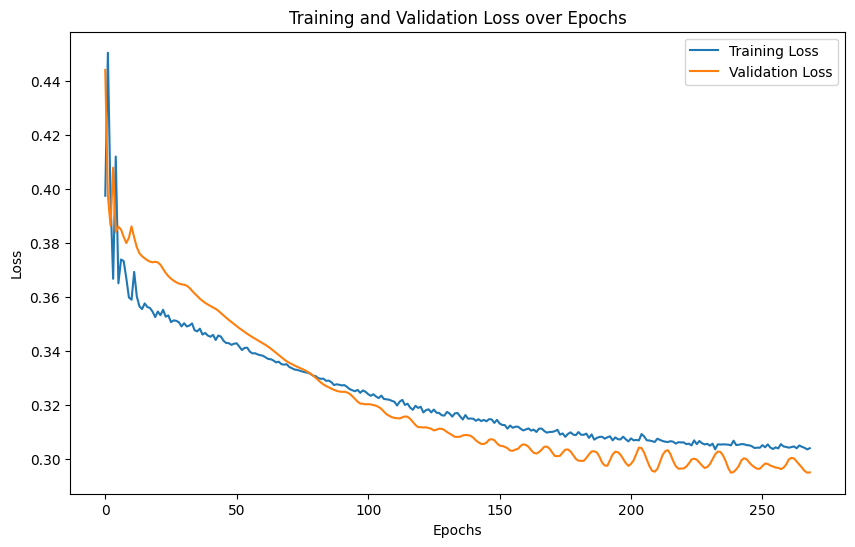

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

class SimpleGNN(torch.nn.Module):
    def __init__(self, input_features, num_layers=3):
        super(SimpleGNN, self).__init__()
        self.layers = torch.nn.ModuleList()

        # Input layer
        self.layers.append(GCNConv(input_features, 256, aggr='sum'))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(256, 256, aggr='sum'))
        
        # Output layer
        self.layers.append(GCNConv(256, 1, aggr='sum'))

    def forward(self, data):
        x = data.x
        for layer in self.layers[:-1]:
            x = layer(x, data.all_sample_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.layers[-1](x, data.all_sample_index)
        out = torch.sigmoid(x)

        edge_out = out[data.all_sample_index[0]] * out[data.all_sample_index[1]]
        return edge_out

# Use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a model and optimizer
input_features = train_data.num_features
num_layers = 5 
model = SimpleGNN(input_features, num_layers=num_layers).to(device)
train_data = train_data.to(device)
valid_data = valid_data.to(device)
test_data = test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_labels = train_data.labels.to(device)
valid_labels = valid_data.labels.to(device)

# Training settings
patience = 30  # Number of epochs to wait for improvement before stopping
early_stopping_counter = 0
best_validation_loss = float('inf')

# For plotting
train_losses = []
valid_losses = []

model.train()  # Ensure the model is in training mode
for epoch in range(10000):
    # Training step
    optimizer.zero_grad()
    edge_out = model(train_data)
    train_loss = F.binary_cross_entropy(edge_out.squeeze(), train_labels.float().squeeze())
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_out = model(valid_data)
        val_loss = F.binary_cross_entropy(val_out.squeeze(), valid_labels.float().squeeze())
    model.train()  # Set the model back to training mode

    # Store losses for plotting
    train_losses.append(train_loss.item())
    valid_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss < best_validation_loss:
        best_validation_loss = val_loss
        early_stopping_counter = 0  # Reset counter if validation loss improves
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Print losses for each epoch
    print(f"Epoch: {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()


## Evaluate Model

In [16]:
import os
import torch
import pandas as pd
from torch_geometric.nn import global_sort_pool
from torch_geometric.loader import DataLoader
from torchmetrics.functional.retrieval import retrieval_reciprocal_rank
from tqdm import tqdm

def find_tensor_indices(candidate_index, row_value, col_values):
    # Convert col_values to tensor if it's a list
    col_values = torch.tensor(col_values) if isinstance(col_values, list) else col_values

    row_mask = (candidate_index[0, :] == row_value)
    col_mask = torch.isin(candidate_index[1, :], col_values)
    final_mask = row_mask & col_mask
    return torch.nonzero(final_mask).squeeze()

def map_ids(df, mapping_dict, column_name):
    return df[column_name].map(mapping_dict)
# MRR 
def create_retrieval_df(model, user_id_map, item_id_map, sample_df, data, data_dir, file_name='trained_model.pth'):
    model.eval()
    out = model(data)
    predictions, targets = out.detach().cpu().squeeze(), data.labels.detach().cpu()
    print('Test predictions:', predictions)
    print('Test targets:', targets)
    
    # Save the trained model
    torch.save(model.state_dict(), os.path.join(data_dir, file_name))

    candidate_index = data.all_sample_index.detach().cpu()
    retrieval_df = sample_df.copy()

    retrieval_df['user_node_id'] = map_ids(retrieval_df, user_id_map, 'user')
    retrieval_df['positive_item_id'] = map_ids(retrieval_df, item_id_map, 'positive_song_id')
    retrieval_df['candidate_item_ids'] = retrieval_df['candidates'].apply(lambda x: [item_id_map[c] for c in x])
    retrieval_df['labels'] = retrieval_df.apply(lambda x: [int(c == x['positive_item_id']) for c in x['candidate_item_ids']], axis=1)
    display(retrieval_df.head())

    query_results_list = []
    reciprocal_rank_list = []

    for i, record in tqdm(retrieval_df.iterrows(), desc='Calculating reciprocal rank', total=retrieval_df.shape[0]):
        candidate_items = record['candidate_item_ids']
        user_id = record['user_node_id']
        query_labels = record['labels']

        indices = find_tensor_indices(candidate_index, user_id, candidate_items)
        query_target_nodes = pd.Series(candidate_index[1, indices], name='candidate_nodes')
        query_predictions = pd.Series(predictions[indices],  index=query_target_nodes, name='predictions', dtype = 'float')
        query_labels_series = pd.Series(query_labels, index=pd.Series(candidate_items, name='candidate_nodes'), name='labels', dtype='int')

        query_results = pd.merge(query_predictions, query_labels_series, on='candidate_nodes').reset_index().drop_duplicates()
        query_results['source_node'] = user_id
        query_results['query_id'] = i

        reciprocal_rank = retrieval_reciprocal_rank(
            torch.tensor(query_results['predictions'].values),
            torch.tensor(query_results['labels'].values))

        query_results = query_results.groupby(['query_id', 'source_node']).agg({'candidate_nodes': list, 'predictions': list, 'labels': list}).reset_index()
        query_results['reciprocal_rank'] = reciprocal_rank

        reciprocal_rank_list.append(reciprocal_rank)
        query_results_list.append(query_results)

    return pd.concat(query_results_list, ignore_index=True)


### Calculate Reciprocal Rank

In [17]:
retrieval_df = create_retrieval_df(model,valid_user_id_map, valid_item_id_map, valid, valid_data, data_dir)
print(f'Mean Reciprocal Rank: {retrieval_df.reciprocal_rank.mean()}')

Test predictions: tensor([0.0728, 0.0742, 0.0722,  ..., 0.0679, 0.0713, 0.0713])
Test targets: tensor([0., 0., 0.,  ..., 0., 0., 0.])


,user,past_interactions,candidates,positive_song_id,user_node_id,positive_item_id,candidate_item_ids,labels
0,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[96, 46, 46, 46, 46, 232, 325, 232, 125, 325]","[1345, 117, 1069, 593, 166, 659, 125, 41, 2381...",125,33,121,"[115, 116, 117, 118, 119, 120, 121, 122, 123, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[46, 46, 46, 46, 232, 325, 232, 125, 325, 125]","[1728, 1821, 1314, 232, 1464, 1541, 1018, 2343...",232,33,128,"[125, 126, 127, 128, 129, 130, 131, 132, 133, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[46, 46, 46, 232, 325, 232, 125, 325, 125, 232]","[16, 717, 1220, 73, 729, 1064, 46, 219, 423, 896]",46,33,141,"[135, 136, 137, 138, 139, 140, 141, 142, 143, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[46, 46, 232, 325, 232, 125, 325, 125, 232, 46]","[96, 2450, 892, 592, 350, 681, 2439, 133, 2421...",96,33,145,"[145, 146, 147, 148, 149, 150, 151, 152, 153, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1001b22c8e4adeb77ef10481ad06ff9c35006cb3,"[46, 232, 325, 232, 125, 325, 125, 232, 46, 96]","[441, 1462, 325, 311, 115, 2097, 294, 395, 121...",325,33,157,"[155, 156, 157, 158, 159, 160, 161, 162, 163, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


Calculating reciprocal rank: 100%|██████████| 14793/14793 [01:06<00:00, 221.96it/s]


Mean Reciprocal Rank: 0.8534321818174136


In [112]:
retrieval_df.to_pickle(os.path.join(data_dir,'test_results_mrr_baseline_v1.pickle'))

In [18]:
test_df = retrieval_df.sample(15)
test_df

,query_id,source_node,candidate_nodes,predictions,labels,reciprocal_rank
1739,1739,37,"[717, 1347, 505, 1129, 272, 1110, 315, 925, 21...","[0.1963772177696228, 0.0701255202293396, 0.067...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tensor(1.)
380,380,34,"[521, 1073, 1211, 1834, 1412, 1113, 832, 1330,...","[0.07278770208358765, 0.07586710900068283, 0.0...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",tensor(1.)
13681,13681,77,"[922, 1953, 1876, 1088, 1875, 1243, 314, 2075,...","[0.11125066876411438, 0.07278769463300705, 0.0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tensor(1.)
7057,7057,28,"[2202, 1074, 1746, 814, 1979, 1676, 1760, 375,...","[0.07162196189165115, 0.08082475513219833, 0.0...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",tensor(1.)
1701,1701,37,"[717, 1407, 886, 1381, 1119, 2060, 1739, 2227,...","[0.1963772177696228, 0.06565732508897781, 0.07...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tensor(1.)
12034,12034,96,"[337, 1386, 1944, 874, 1727, 2251, 311, 1933, ...","[0.08328261971473694, 0.07559416443109512, 0.0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tensor(0.5000)
5097,5097,61,"[1502, 203, 317, 1544, 2150, 739, 1076, 1590, ...","[0.08447752147912979, 0.07476729899644852, 0.0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tensor(1.)
5709,5709,84,"[899, 453, 454, 1373, 1728, 2261, 1143, 1474, ...","[0.07448889315128326, 0.07420911639928818, 0.0...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",tensor(0.1111)
8088,8088,107,"[1214, 529, 1271, 807, 1329, 1328, 858, 1535, ...","[0.07504434883594513, 0.08447752147912979, 0.0...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",tensor(0.5000)
545,545,34,"[1285, 1708, 1711, 440, 1059, 1981, 582, 2032,...","[0.10908766835927963, 0.07220814377069473, 0.0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tensor(1.)
